# Sample Model – Training

The following script demonstrates how to train a model.

For this example, let's assume...

1. We want to train a classifier for the modality of a trace.

2. There are two data sources.
  - Source A: traces may or may not be unique. 
  - Source B: traces are unique.

3. We're re-training a model.
  - A model was trained and tested. We want to add the false predictions from the test set to our training data and re-train a model. This process is analogous to hard negative mining in computer vision projects.
  - We re-training the model starting from random weights.
  
4. Traces are stored in multiple line-delimited json files.
  - Each line in a file is a GeoJSON LineString feature (a trace).

In [1]:
# Print all lines in a jupyter notebook cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## Environment Setup

### Start Spark Session

In [2]:
import os
import psutil

gb = 1024 * 1024 * 1024
num_cores = psutil.cpu_count()
gb_memory = round(psutil.virtual_memory().free / gb, 1)
print(str(num_cores) + ' cores, ' + str(gb_memory) + ' GB memory')

4 cores, 4.1 GB memory


In [3]:
num_parallelism = num_cores * 4

In [4]:
import findspark
findspark.init()

import pyspark

pyspark.__version__

'2.3.1'

In [5]:
%%bash
spark-shell --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.3.1
      /_/
                        
Using Scala version 2.11.8, Java HotSpot(TM) 64-Bit Server VM, 1.8.0_92
Branch 
Compiled by user vanzin on 2018-06-01T20:37:04Z
Revision 
Url 
Type --help for more information.


In [6]:
# Create spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Sample Model Training") \
        .config('spark.jars.packages', 'databricks:tensorframes:0.5.0-s_2.11') \
        .config('spark.sql.codegen.wholeStage', False) \
        .config("spark.sql.caseSensitive", True) \
        .config("spark.default.parallelism", num_parallelism) \
        .config("spark.sql.shuffle.partitions", num_parallelism) \
        .getOrCreate()

In [7]:
# Use the Spark UI to kill tasks
spark

### Check Keras and Tensorflow version

In [8]:
import keras
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


In [9]:
# Check version: must use keras >2.2.1 for StatefulMetrics, tf 1.10.0 for tensorframes 0.5.0
keras.__version__
tf.__version__

'2.2.2'

'1.10.0'

In [10]:
# Check tensorframes python bining (scroll down to FILE section): must use the python package inside databricks_tensorframes-0.5.0-s_2.11.jar
help('tensorframes')

Help on package tensorframes:

NAME
    tensorframes - TensorFrames, a TensorFlow binding library for Scala/Spark.

DESCRIPTION
    This modules provides methods to manipulate Spark DataFrames with TensorFlow numerical graphs.
    
    Core API
    --------
    
    The API lets users manipulate Spark dataframes using standard big data operations such as map,
    reduce and aggregate. These operations come usually in two flavors: block and row. In a block
    operation, multiple rows of data are manipulated at once (and the TensorFlow program that
    expresses this transformation must accept these blocks). In a row operation, each row is processed
    one at a time.
    
    The most important operations available in this module are:
    
     - map_rows: adds extra columns one row at time
     - map_blocks: adds extra columns block by block
     - reduce_rows: applies a transform on pairs of rows until one row is left
     - reduce_blocks: applies a transform on blocks or rows until 

### Load dependencies

In [11]:
# Plot prettier confusion matrices with Seaborn (`pip install seaborn` if not already installed).
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})

In [12]:
# Trace classifier functions
from trace_classifier.config import load_config
from trace_classifier.utils import getGeojsonSchema
from trace_classifier.train import compute_class_weight
from trace_classifier.preprocessing import include_id_and_label
from trace_classifier.preprocessing import preprocessing_part1
from trace_classifier.preprocessing import preprocessing_part2
from trace_classifier.preprocessing import preprocessing_part3
from trace_classifier.architecture import architecture
from trace_classifier.cross_validation import k_fold_CV
from trace_classifier.cross_validation import summarize_performance
from trace_classifier.save import save_model
from trace_classifier.load import get_metadata
from trace_classifier.load import load_model
from trace_classifier.load import load_model_metadata
from trace_classifier.evaluate import confusion_matrix
from trace_classifier.evaluate import plot_confusion_matrix
from trace_classifier.infer import infer
from trace_classifier.infer import avg_probability
from trace_classifier.write import write_traces
from trace_classifier.write import write_dataframe
from trace_classifier.read import read_dataframe
from trace_classifier.utils import random_int_column

## Load Data

We want to all the data first into two sets:
- A train-val set, which later will be further split into a training set and a validation set.
- A hold-out test set, which is reserved for final testing. Once tested on a model, this test set is no longer usable as a test set (but can still be used as a validation set).

Depending on the problem, we might be able split data based on source (e.g. train-val set consists of Source A traces only, test set contains Source B traces only). 

Let's assume that our problem requires that both sets to contain traces from all sources.

In [13]:
from pyspark.sql.functions import lit

In [14]:
schema = getGeojsonSchema()

### Load Traces from Source A

Source A may contain duplicate traces. We cannot randomly shuffle and split the traces into a train-val set and a test set, because it's possible that the test set will contain traces that are identical to traces in the training set. This is a form of data leakage. 

We must split the traces by one or more properties that guarantee duplicate traces are assigned to the same set. Some examples are

- longitude (any trace within this longitude range is reserved as the test set; everything else belongs to the train-val set)
- latitude (any trace within this latitude range is reserved as the test set; everything else belongs to the train-val set)
- altitude (any trace within this altitude range is reserved as the test set; everything else belongs to the train-val set)
- timestamp (any trace within this time range is reserved as the test set; everything else belongs to the train-val set)
- ...etc.

Note that even though all these prevents data leakage, not all make sense for the given problem.


Let's assume that we've already manually split the traces from Source A into two sets, each stored in its own directory.

In [15]:
# The dataset is saved as multiple json files
source_A_trn = spark.read.json('../../../trace-classifier-data/source_A_trn/*', schema=schema) \
                    .withColumn('source', lit('Source A'))

source_A_tst = spark.read.json('../../../trace-classifier-data/source_A_tst/*', schema=schema) \
                    .withColumn('source', lit('Source A'))

In [16]:
# Show dataframe schema
source_A_trn.printSchema()

root
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- modality: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = false)



In [17]:
# Stats on trace count in train-val set
source_A_trn.count()
source_A_trn.groupby('properties.modality').count().show()

24671

+-----------+-----+
|   modality|count|
+-----------+-----+
|Not Driving| 7005|
|      Noise| 5135|
|    Driving| 1974|
|      Dunno|10557|
+-----------+-----+



In [18]:
# Stats on trace count in test test
source_A_tst.count()
source_A_tst.groupby('properties.modality').count().show()

2642

+-----------+-----+
|   modality|count|
+-----------+-----+
|Not Driving|  779|
|      Noise|  454|
|    Driving|  190|
|      Dunno| 1219|
+-----------+-----+



The only data trace-classifier needs to train a model are 
- coordinates, which must be stored in a column named `coordinates`. 
- the class of each trace, which in our example is the modality.

To reduce amount of data that we need to serialize and copied in spark, let's select only the columns trace-classifier need.

As an example, let's also assume we only want to train a classifier that can infer 3 out of the 4 available classes.

In [19]:
# Select only relevant data
relevant_fields = ['geometry.coordinates', 'properties.modality', 'source']
condition = 'properties.modality == "Driving" OR ' + \
            'properties.modality == "Not Driving" OR ' + \
            'properties.modality == "Noise"'

source_A_trn = source_A_trn.select(relevant_fields) \
                           .where(condition)

source_A_tst = source_A_tst.select(relevant_fields) \
                           .where(condition)

In [20]:
# Print new schema and trace counts
source_A_trn.printSchema()
source_A_trn.count()
source_A_tst.count()

root
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- modality: string (nullable = true)
 |-- source: string (nullable = false)



14114

1423

### Load Traces from Source B

Source B contains only unique traces. We can therefore do a simple random shuffle and then split the data into two sets.

In [21]:
source_B = spark.read.json('../../../trace-classifier-data/source_B/*', schema=schema) \
                .withColumn('source', lit('Source B'))

In [22]:
# Print schema
source_B.printSchema()

root
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- modality: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = false)



In [23]:
# Print stats on trace count
source_B.count()
source_B.groupby('properties.modality').count().show()

4000

+--------+-----+
|modality|count|
+--------+-----+
|    null| 4000|
+--------+-----+



Looks like modality is missing from the json files. For simplicity, let's assume we know what devices were used to collect these traces, and so we know what their modalities are; we just need to add this information to this dataframe. 

For simplicity, let's assume traces from source B are all of the same modality, say, `Driving`.

In [24]:
source_B = source_B.withColumn('modality', lit('Driving'))
source_B.groupby('properties.modality').count().show()

+--------+-----+
|modality|count|
+--------+-----+
|    null| 4000|
+--------+-----+



In [25]:
# Downsample source_B to create a more balanced dataset. This is not required in the current example, 
# but leaving the code here in case someone needs it.

target = 4000

if (source_B.count() > target):
    fraction = float(target) / source_B.count()
    source_B = source_B.sample(withReplacement=False, fraction=fraction)

    source_B.count()

In [26]:
# Randomly assigns traces to a set by re-using the functions designed for k-fold cross validation.

# Let's say we want to reserve 10% of the traces from Source B as the hold-out test set.
# First randomly assigns each trace an integer in [0, 10)
source_B = random_int_column(source_B, 0, 10, 'fold')

# Select all the traces with integer greater than 0 – let this be the train-val set.
source_B_trn = source_B.where('fold != 0')

# Select all the traces with integer 0 – let this be the test set.
source_B_tst = source_B.where('fold == 0')

In [27]:
# Select only the columns trace-classifier needs
relevant_fields = ['geometry.coordinates', 'modality', 'source']
source_B_trn = source_B_trn.select(relevant_fields)
source_B_tst = source_B_tst.select(relevant_fields)

In [28]:
# Print schema and trace count stats
source_B_trn.printSchema()
source_B_trn.count()
source_B_tst.count()

root
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- modality: string (nullable = false)
 |-- source: string (nullable = false)



3568

432

### Load Traces that were Falsely Predicted

There are the traces that were falsely predicted (predicted modality is not the true modality) by the previous model. We want to add all these traces into the train-val set so that the new model learns these tricky edge cases; therefore, there's no need to split this set into train-val and test.

For simplicity, let's again all these traces have the same (true) modality. For the sake of demonstrating how to use class weight in model training, let's assume the modalit is also `Driving`, so our final training set will be dominated by driving traces.

In [29]:
file_path = '../../../trace-classifier-data/falsely_predicted/*'
falsely_predicted = spark.read.json(file_path, schema=schema) \
                         .withColumn('modality', lit('Driving')) \
                         .withColumn('source', lit('Falsely Predicted')) \
                         .select(['geometry.coordinates', 'modality', 'source'])

In [30]:
# Print schema and trace count stats   
falsely_predicted.printSchema()
falsely_predicted.count()
falsely_predicted.groupby('modality').count().show()

root
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- modality: string (nullable = false)
 |-- source: string (nullable = false)



8799

+--------+-----+
|modality|count|
+--------+-----+
| Driving| 8799|
+--------+-----+



### Concatenate

So the final datasets are:
- train-val set = {Source A train-val set, Source B train-val set, falsely predicted traces}
- test set = {Source B train-val set, Source B train-val set}

In [31]:
# Concatenate
final_trn = source_A_trn.unionByName(source_B_trn) \
                        .unionByName(falsely_predicted)
final_tst = source_A_tst.unionByName(source_B_tst)

In [32]:
# Print schema and trace count stats
final_trn.printSchema()
final_trn.count()
final_tst.count()

root
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- modality: string (nullable = true)
 |-- source: string (nullable = false)



26481

1855

In [33]:
# Show 3 rows as example
final_trn.show(3)

+--------------------+-----------+--------+
|         coordinates|   modality|  source|
+--------------------+-----------+--------+
|[[2.3543564, 48.8...|    Driving|Source A|
|[[2.3449379, 48.8...|    Driving|Source A|
|[[2.3325944, 48.8...|Not Driving|Source A|
+--------------------+-----------+--------+
only showing top 3 rows



In [34]:
# Show breakdown of traces in the train-val set
final_trn.groupBy('source', 'modality').count().show()

+-----------------+-----------+-----+
|           source|   modality|count|
+-----------------+-----------+-----+
|         Source A|      Noise| 5135|
|         Source A|Not Driving| 7005|
|         Source A|    Driving| 1974|
|         Source B|    Driving| 3568|
|Falsely Predicted|    Driving| 8799|
+-----------------+-----------+-----+



In [35]:
# Show breakdown of traces in the test set
final_tst.groupBy('source', 'modality').count().show()

+--------+-----------+-----+
|  source|   modality|count|
+--------+-----------+-----+
|Source A|      Noise|  454|
|Source A|Not Driving|  779|
|Source A|    Driving|  190|
|Source B|    Driving|  432|
+--------+-----------+-----+



## Prep

Repartition the final datasets for better performance. `repartition` shuffles data to create partitions of roughly equal size, whereas `coalesce` combines partitions without shuffling. So even though coalesce finishes faster than repartition, subsequent operations are slower because dataset is skewed.

In [36]:
# Repartition if needed to speed up preprocessing
if final_trn.rdd.getNumPartitions() > num_parallelism:
    final_trn = final_trn.repartition(num_parallelism) 
    
if final_tst.rdd.getNumPartitions() > num_parallelism:
    final_tst = final_tst.repartition(num_parallelism) 

In [37]:
# Print number of partitions
final_trn.rdd.getNumPartitions()
final_tst.rdd.getNumPartitions()

16

16

Let's save the repartitioned datasets to disk for the sake of demonstrating how to read/write dataframes.

In [38]:
dataset_dir = '../../../trace-classifier-data/final_dataset'
write_dataframe(os.path.join(dataset_dir, 'trn'), final_trn, format='parquet')
write_dataframe(os.path.join(dataset_dir, 'tst'), final_tst, format='parquet')

'../../../trace-classifier-data/final_dataset/trn'

'../../../trace-classifier-data/final_dataset/tst'

## K-Fold CV

In [39]:
# Load training configuration
config = load_config('./config.json')

Let's start by loading the data we saved in Section 3.

In [40]:
df = read_dataframe('../../../trace-classifier-data/final_dataset/trn', format='parquet')
df.show(3)

+--------------------+-----------+--------+
|         coordinates|   modality|  source|
+--------------------+-----------+--------+
|[[18.0680422, 59....|Not Driving|Source A|
|[[2.3500393, 48.8...|Not Driving|Source A|
|[[18.0725669, 59....|      Noise|Source A|
+--------------------+-----------+--------+
only showing top 3 rows



In [41]:
from pyspark.sql.functions import sum as vsum
from pyspark.sql.functions import col
from pyspark.sql.functions import round as vround
from pyspark.sql.window import Window

# Print trace count stats
stats = df.groupby('modality').count()
stats = stats.withColumn('percent', 
                         vround(col('count') / vsum('count').over(Window.partitionBy()) * 100)) 
stats.show()

+-----------+-----+-------+
|   modality|count|percent|
+-----------+-----+-------+
|Not Driving| 7005|   26.0|
|      Noise| 5135|   19.0|
|    Driving|14341|   54.0|
+-----------+-----+-------+



Notice how the dataset is imbalanced: over half the traces are `Driving`. To balance the dataset, we can
- Option 1: downsample `Driving` traces (take a subset of `Driving`) – see Section 2.2 for an example on how to downsample a dataframe.
- Option 2: updample `Not Driving` and `Noise` traces
- Option 3: value `Driving` traces less by giving them a smaller weight during training. 

Let's go with option 3.

In [42]:
# Compute weight
# (pyspark implementation of http://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)
klass_weights = compute_class_weight(df, 'modality')

label_weights = {}
for i, klass in enumerate(config['INPUT']['classes']):
    label_weights[i] = klass_weights[klass]

# Change the class weight in config
config['TRAIN']['FIT']['class_weight'] = label_weights
config['TRAIN']['FIT']['class_weight']

{0: 1.2600999286224126, 1: 0.6155079841015271, 2: 1.718987341772152}

Note that this just makes the training set *roughly* balanced and not strictly balanced. This is because during proprocessing, traces will be split into pieces and the model learns to predict the modality of these pieces. Since traces have different lengths, we don't know how many pieces there are for each modality until preprocessesing is done. (This is not hard to implement; I just didn't do it because I had no need for it.)

Here's the high-level workflow for turning traces into model input (see `preprocessing.py` for more information):

![image](./img/flowchart1.png)

For *k*-fold cross validation, we need to repeat this *k* times... not cool. 

Notice traces in the validation set goes through the `include_id_and_label` and `preprocessing_part1` just like the traces in the training set; these steps are do not depend on the training set, unlike `preprocessing_part2`. Therefore, we can save some computation time by pushing down the train/val split to after `preprocessing_part1`:

![flowchart2](./img/flowchart2.png)

In [43]:
df2 = include_id_and_label(df, 'modality', config['INPUT']['classes'], config['TRAIN']['k_fold_cv'], seed=123)
df2.show(3)

+--------------------+--------+---+-----+----+
|         coordinates|  source| id|label|fold|
+--------------------+--------+---+-----+----+
|[[18.0680422, 59....|Source A|  0|    0|   1|
|[[2.3500393, 48.8...|Source A|  1|    0|   2|
|[[18.0725669, 59....|Source A|  2|    2|   2|
+--------------------+--------+---+-----+----+
only showing top 3 rows



In [44]:
df2 = preprocessing_part1(df2, config['PREPROCESS'])
df2.show(3)

+--------+----+-----+---+--------+--------------------+
|  source|fold|label| id|word_pos|                word|
+--------+----+-----+---+--------+--------------------+
|Source A|   1|    0|  0|       0|[[18.0680422, 59....|
|Source A|   1|    0|  0|       1|[[18.0681326, 59....|
|Source A|   1|    0|  0|       2|[[18.0681985, 59....|
+--------+----+-----+---+--------+--------------------+
only showing top 3 rows



In [45]:
# Cache for k-fold CV – note: this assumes the entire dataset can be fit into memeory
df2.cache()
df2.count();  # Use count to force Spark to execute a transformation.
              # Trailing semicolon suppresses the printing of output.

In [46]:
# Train *k* models 
# (Run 5 epochs only to keep the log short, as this notebook is meant to show how to use trace-classifier and 
# not how the model performs)
model_performance = k_fold_CV(architecture, config, df2, n_epochs=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 15, 2)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 9, 16)        240         input[0][0]                      
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8, 16)        272         input[0][0]                      
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 16)           0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
global_max

In [47]:
# Summarize performance
summary = summarize_performance(model_performance)
summary

{'average': 0.7483333333333334,
 'best': 0.756875,
 'best_model': '20181011-3',
 'best_model_vfold': 2,
 'worst': 0.743125}

### Save Model

In [48]:
# Clean session to speed up saving
K.clear_session()
tf.reset_default_graph()

In [49]:
# Load the best model out of the *k* models
model_to_freeze, metadata = load_model(config['SAVE']['saved_model_dir'], 
                                       summary['best_model'])

In [50]:
model_name = 'sample_model'
save_model(model_to_freeze, 
           config['SAVE']['saved_model_dir'], 
           model_name, 
           metadata=metadata)

Saved compiled model to ../../model/sample_model.h5
Appended metadata to ../../model/sample_model.h5
Saved metadata to ../../model/sample_model_metadata.json
Saved checkpoint to ../../model/byproducts/sample_model.ckpt
Saved graph to ../../model/byproducts/sample_model.pbtxt
INFO:tensorflow:Restoring parameters from ../../model/byproducts/sample_model.ckpt
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
Saved frozen graph to ../../model/byproducts/sample_model_frozen.pb
Saved optimized frozen graph to ../../model/sample_model_optimised_frozen.pb
Removed byproducts in ../../model/byproducts


## Tests

### Load Model

In [51]:
model_name = 'sample_model'

In [52]:
model_path = os.path.join(config['SAVE']['saved_model_dir'], 
                          model_name + '_optimised_frozen.pb') 

In [53]:
metadata = load_model_metadata(model_path)
assert metadata is not None

### Load Test Data

In [54]:
# This is the test data saved in Section 3
df_tst = read_dataframe('../../../trace-classifier-data/final_dataset/tst', 
                        format='parquet')
df_tst.show(3)

+--------------------+-----------+--------+
|         coordinates|   modality|  source|
+--------------------+-----------+--------+
|[[18.0678805, 59....|    Driving|Source A|
|[[18.070929, 59.3...|Not Driving|Source A|
|[[18.0713429, 59....|Not Driving|Source A|
+--------------------+-----------+--------+
only showing top 3 rows



### Piece-wise Prediction Results

In [55]:
rdf = infer(df_tst, model_path, aggregate=False)
rdf.show(3)

+--------------------+--------+--------+---+----------+--------------------+----------+-------------+
|              probas|modality|  source| id|phrase_pos|              phrase|word_count|pred_modality|
+--------------------+--------+--------+---+----------+--------------------+----------+-------------+
|[0.15017952, 0.74...| Driving|Source A| 10|         6|[[-0.33, 0.36], [...|        15|      Driving|
|[0.4973646, 0.288...| Driving|Source A| 23|         0|[[-0.18, 0.63], [...|        15|  Not Driving|
|[0.24822879, 0.56...| Driving|Source A| 23|         4|[[-0.1, 0.76], [-...|        15|      Driving|
+--------------------+--------+--------+---+----------+--------------------+----------+-------------+
only showing top 3 rows



In [56]:
phrase_cm = confusion_matrix(rdf, 'modality', 'pred_modality', metadata['classes'])
phrase_cm

array([[1978,  363,   47],
       [ 286, 2485,   12],
       [ 256,  420,   65]])

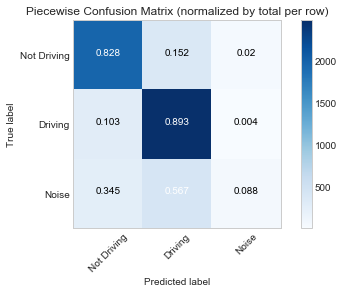

In [57]:
plot_confusion_matrix(phrase_cm, 
                      metadata['classes'], 
                      normalize='row', 
                      title='Piecewise Confusion Matrix (normalized by total per row)')

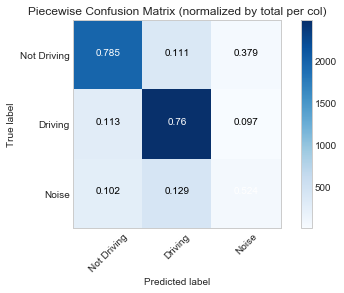

In [58]:
plot_confusion_matrix(phrase_cm, 
                      metadata['classes'], 
                      normalize='col', 
                      title='Piecewise Confusion Matrix (normalized by total per col)')

### Full-Trace Prediction Results

In [59]:
rdf = infer(df_tst, model_path, aggregate=True)
rdf.show(3)

+-----------+--------------------+--------+--------+--------------------+-------------+
|         id|         coordinates|modality|  source|              probas|pred_modality|
+-----------+--------------------+--------+--------+--------------------+-------------+
|17179869203|[[2.1816651, 41.3...| Driving|Source A|[0.11859928871945...|      Driving|
|25769803776|[[18.0682688, 59....| Driving|Source A|[0.19512984789842...|      Driving|
|42949672963|[[18.0610076, 59....| Driving|Source A|[0.01622189296977...|      Driving|
+-----------+--------------------+--------+--------+--------------------+-------------+
only showing top 3 rows



In [60]:
sentence_cm = confusion_matrix(rdf, 'modality', 'pred_modality', metadata['classes'])
sentence_cm

array([[606, 162,  11],
       [ 18, 604,   0],
       [143, 276,  35]])

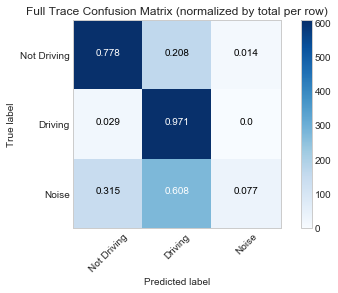

In [61]:
plot_confusion_matrix(sentence_cm, 
                      metadata['classes'], 
                      normalize='row', 
                      title='Full Trace Confusion Matrix (normalized by total per row)')

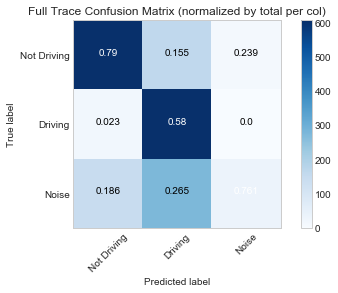

In [62]:
plot_confusion_matrix(sentence_cm, 
                      metadata['classes'], 
                      normalize='col', 
                      title='Full Trace Confusion Matrix (normalized by total per col)')

# The End.